In [84]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
import numpy as np
from dataclasses import dataclass
from math import erf, sqrt

def normal_cdf(x):
    # Φ(x) using erf (no SciPy needed)
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

@dataclass
class ValuationRegime:
    start: int      # inclusive (1-indexed time)
    end: int        # inclusive
    mu: float       # mean valuation in this regime
    sigma: float    # std dev (kept constant across regimes for simplicity)

class NonStationaryValuationEnv:
    """
    Non-stationary single-product pricing environment.
    Each regime defines V_t ~ Normal(mu, sigma).
    Conversion probability at round t: q_t(p) = P(V_t >= p) = 1 - Φ((p - mu)/sigma).
    """
    def __init__(self, regimes, cost):
        self.regimes = regimes  # list[ValuationRegime]
        self.cost = float(cost)
        self.rng = np.random.default_rng(123)

    def _regime_at(self, t):
        for reg in self.regimes:
            if reg.start <= t <= reg.end:
                return reg
        return self.regimes[-1]

    def conversion_probability(self, p, t):
        reg = self._regime_at(t)
        z = (p - reg.mu) / reg.sigma
        q = 1.0 - normal_cdf(z)
        return float(np.clip(q, 0.0, 1.0))

    def round(self, t, p_t, n_t=1):
        """
        Simulate one round at time t with posted price p_t to n_t customers.
        Returns:
          d_t : realized demand (units sold)
          r_t : realized revenue ( (p_t - cost) * d_t )
          q_t : conversion probability used this round (for logging/debug)
        """
        q_t = self.conversion_probability(p_t, t)
        d_t = self.rng.binomial(n_t, q_t)
        r_t = (p_t - self.cost) * d_t
        return int(d_t), float(r_t), float(q_t)


In [86]:
import numpy as np

class PrimalDualEXP3Agent:
    """
    Primal–dual pricing with an EXP3-style arm update (non-stationary robust)
    and a dual update for the inventory constraint.

    - Prices: discrete grid (arms)
    - Primal update: EXP3 on importance-weighted Lagrangian gains
    - Dual update: λ_{t+1} = [ λ_t + η_λ ( d_t - B/T ) ]_+
    """
    def __init__(self, prices, B, T, cost, n_t=1, gamma=0.05, eta_arm=None,
                 eta_lambda=None, lam0=0.0, forget=0.002, seed=7):
        self.prices = np.array(prices, dtype=float)
        self.K = len(self.prices)
        self.B = float(B)
        self.T = int(T)
        self.cost = float(cost)
        self.n_t = int(n_t)

        # EXP3 parameters
        self.gamma = float(gamma)
        self.eta_arm = float(eta_arm) if eta_arm is not None else np.sqrt(2*np.log(self.K)/(self.K*self.T))

        # Dual step size
        self.eta_lambda = float(eta_lambda) if eta_lambda is not None else max(1e-3, 1.0/np.sqrt(self.T))
        self.lam = float(lam0)

        # Non-stationarity adaptation (weight shrink towards uniform)
        self.forget = float(forget)

        # EXP3 weights / probs
        self.w = np.ones(self.K, dtype=float)
        self.probs = np.ones(self.K, dtype=float) / self.K

        # Scaling for numerical stability (clip gains)
        self.p_max = float(np.max(self.prices))
        self.G_clip = None  # set on first update
        self.rng = np.random.default_rng(seed)

    def _update_probs(self):
        w_norm = self.w / np.sum(self.w)
        self.probs = (1 - self.gamma) * w_norm + self.gamma * np.ones(self.K)/self.K

    def select_price(self):
        """Sample an arm (price) according to EXP3 probabilities."""
        self._update_probs()
        idx = self.rng.choice(self.K, p=self.probs)
        return int(idx), float(self.prices[idx]), float(self.probs[idx])

    def observe_and_update(self, arm_idx, arm_prob, d_t):
        """
        Update EXP3 weights with importance-weighted 'gain':
        g_t = (p - cost - λ) * d_t
        and update the dual variable λ.
        """
        p = self.prices[arm_idx]
        g = (p - self.cost - self.lam) * d_t  # can be negative

        # Initialize/clip scale so the exponentials are stable
        if self.G_clip is None:
            self.G_clip = max(1.0, self.n_t * (self.p_max - self.cost + 5.0))
        g = np.clip(g, -self.G_clip, self.G_clip)

        # Importance-weighted estimator (only for played arm)
        gain_hat = g / max(arm_prob, 1e-12)
        self.w[arm_idx] *= np.exp(self.eta_arm * gain_hat / self.G_clip)

        # Small forgetting to adapt to regime changes
        self.w = (1 - self.forget) * self.w + self.forget * np.ones_like(self.w)

        # Dual (inventory) update: push λ up if we sell faster than B/T
        self.lam = max(0.0, self.lam + self.eta_lambda * (d_t - self.B/self.T))


In [87]:
# Horizon & inventory
T = 1000#0
B = 15000#0
n_t = 100
cost = 5.0
k = 40

# Abrupt regime changes (means jump around)
L = T // 4
sigma = 2.0
regimes = [
    ValuationRegime(1,       L,     mu=10.0, sigma=sigma),
    ValuationRegime(L+1,   2*L,     mu=7.5,  sigma=sigma),
    ValuationRegime(2*L+1, 3*L,     mu=12.0, sigma=sigma),
    ValuationRegime(3*L+1,   T,     mu=8.5,  sigma=sigma),
]
env = NonStationaryValuationEnv(regimes, cost=cost)

# Price grid (arms)
p_grid = np.round(np.linspace(cost + 0.5, 20.0, k), 2)

agent = PrimalDualEXP3Agent(
    prices=p_grid, B=B, T=T, cost=cost, n_t=n_t,
    gamma=0.07, forget=0.003  # good starting values
)


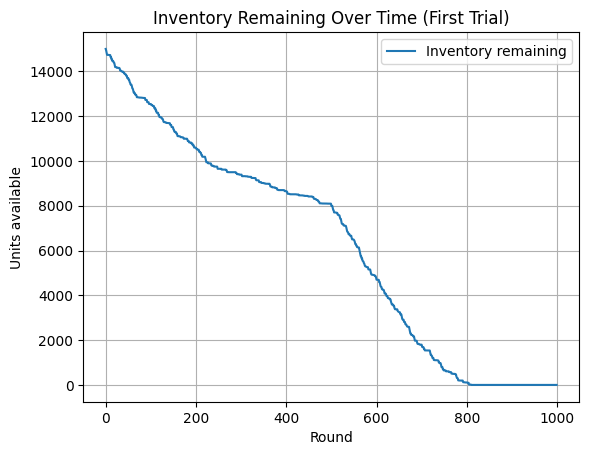

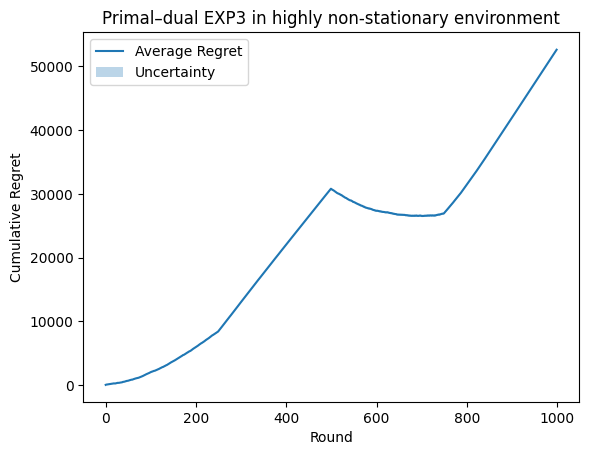

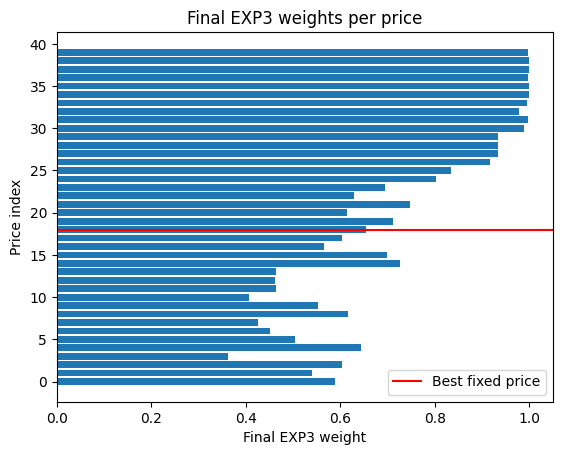

In [88]:
import matplotlib.pyplot as plt

n_trials = 100  # how many repetitions
regret_per_trial = []
inventory_over_time = []


for seed in range(n_trials):
    env = NonStationaryValuationEnv(regimes, cost=cost)
    agent = PrimalDualEXP3Agent(
        prices=p_grid, B=B, T=T, cost=cost, n_t=n_t,
        gamma=0.07, forget=0.003, seed=seed
    )

    agent_rewards = np.zeros(T)
    stock = B
    inventory_this_trial = []  # reset for this trial

    for t in range(1, T + 1):
        arm_idx, p_t, prob = agent.select_price()
        d_t, r_t, q_t = env.round(t, p_t, n_t=n_t)

        # Cap sales by remaining stock
        if d_t > stock:
            d_t = stock
            r_t = (p_t - cost) * d_t

        stock -= d_t
        inventory_this_trial.append(stock)  # <-- track remaining stock

        agent.observe_and_update(arm_idx, prob, d_t)
        agent_rewards[t - 1] = r_t

    if seed == 0:
        plt.figure()
        plt.plot(np.arange(T), inventory_this_trial, label="Inventory remaining")
        plt.title("Inventory Remaining Over Time (First Trial)")
        plt.xlabel("Round")
        plt.ylabel("Units available")
        plt.grid(True)
        plt.legend()
        plt.show()


    # ---- Clairvoyant benchmark ----
    # Here: best fixed price over the WHOLE horizon (knows all regimes in advance)
    exp_revs = []
    for p in p_grid:
        expected_sales = sum(n_t * env.conversion_probability(p, tt) for tt in range(1, T+1))
        exp_sales_capped = min(B, expected_sales)  # can't sell more than inventory
        exp_revs.append((p - cost) * exp_sales_capped)
    best_idx = int(np.argmax(exp_revs))
    best_fixed_price = p_grid[best_idx]
    clairvoyant_reward = exp_revs[best_idx] / T  # per-round average

    expected_clairvoyant_rewards = np.repeat(exp_revs[best_idx] / T, T)

    # ---- Regret ----
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# ---- Plot cumulative regret ----
plt.figure()
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd / np.sqrt(n_trials),
                 average_regret + regret_sd / np.sqrt(n_trials),
                 alpha=0.3, label='Uncertainty')
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Primal–dual EXP3 in highly non-stationary environment')
plt.legend()
plt.show()

# ---- Plot number of pulls per arm ----
plt.figure()
plt.barh(np.arange(k), agent.w)  # final weights (proxy for pulls if not tracked)
plt.axhline(best_idx, color='red', label='Best fixed price')
plt.ylabel('Price index')
plt.xlabel('Final EXP3 weight')
plt.legend()
plt.title('Final EXP3 weights per price')
plt.show()
